# Volatility Forecasts (Part 3 - From STES to Neural Networks)

This notebook demonstrates the implementation of the generalization of the Smooth Transition Exponential Smoothing (STES) model using Neural Networks.
This notebook corresponds to the blog series [Volatility Forecasts (Part 3 - XGBoost-STES)](https://steveya.github.io/2024/07/12/volatility-forecast-3.html). 

In [21]:
%load_ext autoreload
%autoreload 2

import sys
import os
project_dir = os.path.abspath('..')
sys.path.insert(0, project_dir)

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from typing import Tuple
from matplotlib import pyplot as plt

from volatility_forecast.data.datamanager import (
    LagReturnDataManager,
    LagAbsReturnDataManager, 
    LagSquareReturnDataManager,
    SquareReturnDataManager,
)
from volatility_forecast.model.stes_model import STESModel
from volatility_forecast.model.neural_network_model import RNNVolatilityModel
from volatility_forecast.model.neural_network_model import GRUVolatilityModel


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

# Data preparation function
def prepare_data(tickers: Tuple[str], start_date: str, end_date: str):
    returns = LagReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2
    realized_var = SquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4
    feature_sets = np.hstack([
        np.ones((len(returns), 1)),
        LagReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagAbsReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e2,
        LagSquareReturnDataManager().get_data(tickers, start_date, end_date)[0] * 1e4,
    ])
    return feature_sets, realized_var, returns

# Data normalization
def normalize_data(X, y):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_normalized = scaler_X.fit_transform(X)
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    return X_normalized, y_normalized, scaler_X, scaler_y

# Model evaluation function
def evaluate_model(model, X, y, returns, train_size, test_size, **kwargs):
    model.fit(X[:train_size], y[:train_size], returns=returns[:train_size], start_index=0, end_index=train_size, **kwargs)
    predictions = model.predict(X[train_size:train_size+test_size], returns=returns[train_size:train_size+test_size])
    rmse = np.sqrt(mean_squared_error(y[train_size:train_size+test_size], predictions))
    return rmse


In [3]:
# Main execution
tickers = ("SPY",)
start_date = "2000-01-01"
end_date = "2023-12-31"

X, y, returns = prepare_data(tickers, start_date, end_date)
X_normalized, y_normalized, scaler_X, scaler_y = normalize_data(X, y)

train_size = 4000
test_size = 1000


In [4]:


# STES Model
stes_model = STESModel()
stes_rmse = evaluate_model(stes_model, X, y, returns=returns, train_size=train_size, test_size=test_size)
print(f"STES RMSE: {stes_rmse}")


STES RMSE: 1.6432506654016714


In [5]:
y.shape

(6037, 1)

In [22]:

rnn_model = RNNVolatilityModel(input_size=X.shape[1], hidden_size=1)
rnn_rmse = evaluate_model(rnn_model, X, y, returns, train_size, test_size, learning_rate=0.1)
print(f"RNN RMSE: {rnn_rmse}")



Epoch 1/50, Loss: 32.737473
Epoch 2/50, Loss: 32.632969
Epoch 3/50, Loss: 32.538055
Epoch 4/50, Loss: 32.451035
Epoch 5/50, Loss: 32.365788
Epoch 6/50, Loss: 32.289238
Epoch 7/50, Loss: 32.178387
Epoch 8/50, Loss: 32.026226
Epoch 9/50, Loss: 31.804134
Epoch 10/50, Loss: 31.529192
Epoch 11/50, Loss: 31.229395
Epoch 12/50, Loss: 30.983040
Epoch 13/50, Loss: 30.919092
Epoch 14/50, Loss: 30.978439
Epoch 15/50, Loss: 30.942129
Epoch 16/50, Loss: 30.657061
Epoch 17/50, Loss: 30.186312
Epoch 18/50, Loss: 29.869221
Epoch 19/50, Loss: 29.924990
Epoch 20/50, Loss: 30.151842
Epoch 21/50, Loss: 30.380230
Epoch 22/50, Loss: 30.158300
Epoch 23/50, Loss: 29.422689
Epoch 24/50, Loss: 28.681631
Epoch 25/50, Loss: 28.585585
Epoch 26/50, Loss: 29.296450
Epoch 27/50, Loss: 29.637802
Epoch 28/50, Loss: 29.013700
Epoch 29/50, Loss: 27.920252
Epoch 30/50, Loss: 28.381618
Epoch 31/50, Loss: 29.813927
Epoch 32/50, Loss: 29.861073
Epoch 33/50, Loss: 29.820671
Epoch 34/50, Loss: 29.703205
Epoch 35/50, Loss: 29.5

In [29]:
list(rnn_model.parameters())

[Parameter containing:
 tensor([[ 0.7106,  0.2993, -0.3132, -0.7592]], device='mps:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.2235]], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([[0.0084]], device='mps:0', requires_grad=True),
 Parameter containing:
 tensor([0.9662], device='mps:0', requires_grad=True)]

In [ ]:

rnn_model = RNNVolatilityModel(input_size=X.shape[1], hidden_size=3)
rnn_rmse = evaluate_model(rnn_model, X, y, returns, train_size, test_size, learning_rate=0.1)
print(f"RNN RMSE: {rnn_rmse}")



RNN RMSE: 3.4246879243225017


In [27]:

# GRU Model
gru_model = GRUVolatilityModel(input_size=X.shape[1], hidden_size=32)
gru_rmse = evaluate_model(gru_model, X, y, returns, train_size, test_size, learning_rate=0.1)
print(f"GRU RMSE: {gru_rmse}")



TypeError: super(type, obj): obj must be an instance or subtype of type

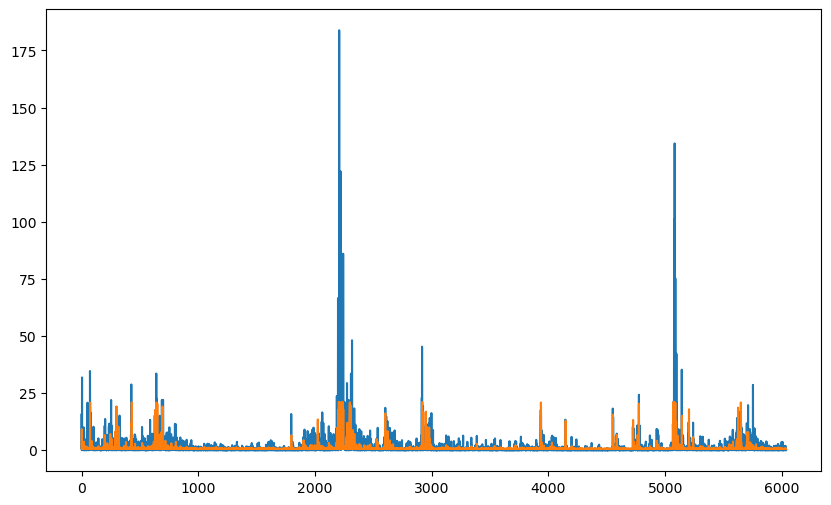

In [26]:
# plot the predicted volatility from STES and RNN
plt.figure(figsize=(10, 6))
plt.plot(y)
plt.plot(rnn_model.predict(X, returns=returns))
#plt.plot(stes_model.predict(X, returns=returns))
plt.show()
